In [435]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [436]:
# Physical constants
grav_cons=const.G
sun_m=(1.989)*10**30        # Mass of the sun in kg 
earth_radius=(6371)*10**3        # Radius of the earth in m 

filename = 'white_dwarf_data.csv'

In [437]:
def data_process(filename):
        # Process the data and convert columns into numpy arrays. Returns logg and mass columns.
        data = pd.read_csv(filename)
        logg = data.loc[:,"logg"].to_numpy()
        mass = data.loc[:,"mass"].to_numpy()

        return logg, mass

In [438]:
def filter_mass(R, threshold):
    # Filters mass and corresponding logg values based on a threshold for mass we select.
    # Apply the threshold filter
    logg, mass = data_process(filename)
    mask = mass <= threshold    # Low mass filter
    mask_large = mass > threshold   # Large mass filter

    low_mass = mass[mask]
    low_R= R[mask]

    large_mass = mass[mask_large]
    large_R= R[mask_large]

    return low_R, low_mass, large_R, large_mass

In [439]:
def le_solver(nstar, xi_f=20):
    # le_solver solves and returns solutions of the Lane-Emden Equation numerically with built-in solve_ivp method.
    # n is the parameter in LE equation where xi_f is the final xi value of integration 

    # Initial value of y
    yinit = np.asarray([1, 0]).astype(float)

    # RHS of LE equation
    def f(t, y):
        # Initialize as zero vector
        f = np.zeros(len(y)) 

        f[0] = y[1]
        if t==0:
            f[1] = 0
        else:
            f[1] = -np.float_power(y[0], nstar) - (2/t) * y[1]
        return f


    sol = solve_ivp(fun=f, t_span=(0, xi_f), y0=yinit, max_step = 1e-5)
    

    xi = sol.t
    theta = sol.y[0,:]
    theta_prime = sol.y[1,:]


    return xi, theta, theta_prime

In [440]:
def calculate_R_M(rho_c, D, q, K_star):
    #Parameters
    C = (5 * K_star * np.float_power(D, 5/q)) / 8
    max_step = 1e5

    #Function to be used in IVP solution (RHS of mass-density ODE)
    def f_rhs(t, y):
        rhs = np.zeros(len(y)) #Initialize RHS to zero

        x = np.float_power(y[1]/D, 1/q) #Calculate x
        df_dx = (8*C*np.float_power(x, 4))/(np.sqrt(np.float_power(x,2) + 1)) #Calculate dP/dx


        rhs[0] = 4*np.pi*np.float_power(t, 2) * y[1]
        if t == 0:
            rhs[1] = 0
        else:
            rhs[1] = (1/df_dx)*q*D*np.float_power(y[1]/D, -(1/q)+1) * (-grav_cons*y[0]*y[1]/np.float_power(t, 2))
        
        return rhs

    #Initial value vector of IVP
    y0 = np.asarray([0, rho_c]).astype(float)

    #Solution of IVP
    solution = solve_ivp(fun=f_rhs, y0=y0, t_span=(0,3e7))
    
    #Return R-M pair
    return solution.t[-1], solution.y[0,-1]

In [441]:
def find_central_density_limits(D, rho_c_initial, n_search_samples, min_R, max_R, q, K_star):
    #Broad range of central density values
    rho_c_vals = rho_c_initial * np.logspace(0.15, 10, n_search_samples)

    #Finding R values of rho_c values
    R_vals = []
    for rho_c in rho_c_vals:
        R,M = calculate_R_M(rho_c=rho_c, D=D, q=q, K_star=K_star)
        R_vals.append(R)

    R_vals = np.asarray(R_vals).astype(float) #Convert to numpy array

    rho_c_min_idx = np.abs(R_vals - min_R).argmin() #İndex of closest element to min R
    rho_c_max_idx = np.abs(R_vals - max_R).argmin() #İndex of closest element to max R

    return rho_c_vals[rho_c_min_idx], rho_c_vals[rho_c_max_idx]

In [442]:
def find_D(radius_arr, mass_arr, rho_c_initial, D_initial, N_samples, q, K_star):
    #Function to be used in built-in minimization function
    def fun_minimize_D(ln_D):
        D = np.exp(ln_D)
        rho_c_min, rho_c_max = find_central_density_limits(D=D, rho_c_initial=rho_c_initial, n_search_samples=10, min_R=np.min(radius_arr), max_R=np.max(radius_arr), q=q, K_star=K_star)
        rho_c_vals = np.logspace(np.log10(rho_c_min), np.log10(rho_c_max), N_samples)
        #err = calculate_err_D(spline_func=spline, rho_c_vals=rho_c_vals, D=np.exp(ln_D))
        #Calculate R-M pairs for given central density vals
        R_vals = []
        M_vals = []
        for rho_c in rho_c_vals:
            R,M = calculate_R_M(rho_c=rho_c, D=D, q=q, K_star=K_star)
            R_vals.append(R)
            M_vals.append(M)

        R_vals = np.asarray(R_vals).astype(float)
        M_vals = np.asarray(M_vals).astype(float)

        indices = np.argsort(R_vals)
        R_vals_sorted = R_vals[indices]
        M_vals_sorted = M_vals[indices]

        # R_vals_unique, unique_indices = np.unique(R_vals_sorted, return_index=True)
        # M_vals_unique = M_vals_sorted[unique_indices]

        # Fit CubicSpline
        spline = CubicSpline(x=R_vals_sorted, y=M_vals_sorted)
        
        #Fitting Spline to calculated values
        #spline = CubicSpline(x=R_vals_sorted, y=M_vals_sorted)

        #Calculate Error
        err = np.sqrt( np.mean(np.float_power(mass_arr - spline(radius_arr), 2)) ) / sun_m

        print('ln(D) = ' + str(ln_D) + '  Err = ' + str(err))

        return err

    result = minimize(fun=fun_minimize_D, x0=[np.log(D_initial)], options={'disp':True, 'ftol':1e-12}, bounds=[(10,np.log(D_initial))])

    return np.exp(result.x[0])

In [443]:
def part_b():
    # This function solve part b of the Newton. From the basic newtonian gravity we can derive: r = sqrt(G*M/g) 
    # Plots M vs R 

    logg, mass = data_process(filename)
    g = (10**logg)/100  # Converted to MKS units

    r = np.sqrt(grav_cons * mass * sun_m/g)
    R = r/earth_radius

    return mass, R

In [444]:
def part_c(R):
     # This function solve part c of the Newton. It filters mass based on a threshold, performs a linear fit into the M-R expression 
     # and solves the Lane-Emden equation numerically

    # Threshold for low mass selection
    threshold = 0.4

    # Get the filtered data based on the threshold.
    # low_mass <= 0.4 <-> low_R
    # large_mass > 0.4 <-> large_R
    low_R, low_mass, large_R, large_mass = filter_mass(R, threshold)

    # Log-log transformation for power-law visualization
    low_R_log, low_mass_log = np.log(low_R), np.log(low_mass)
    large_R_log, large_mass_log = np.log(large_R), np.log(large_mass)


    plt.figure(figsize=(10, 6))
    plt.scatter(low_R_log, low_mass_log, label='Below threshold Stars', alpha=0.4)
    plt.scatter(large_R_log, large_mass_log, label='Above threshold Stars', alpha=0.4)
    
    # Now we perform a linear fit in the form: ln(M) = slope * ln(R) + intercept
    slope, intercept = np.polyfit(low_R_log, low_mass_log, 1)

    # Linear fit line
    x_range = np.linspace(np.min(low_R_log), np.max(low_R_log), len(R))
    lin_fit = intercept + slope * x_range

    plt.plot(x_range, lin_fit, color='red', linestyle='--', label='Linear Fit')
    plt.legend()
    plt.ylabel('log(M)')
    plt.xlabel('log(R)')
    plt.title(f'M-R with Linear Fit for m < {threshold}')
    plt.show()

    print(f'Calculated slope: {slope:.3f}')

    # Constants for calculations. Although we've found slope to be in decimals, theoretically it should be an integer.
    # So we round it to -3. nstar can be calculated by plugging -3 into the slope expression.
    nstar = 1.5
    slope_true = -3

    # Solutions of the LE equation
    xi, theta, theta_prime = le_solver(nstar, 15)
    xi_final, theta_final, theta_prime_final = xi[-1], theta[-1], theta_prime[-1]   # Final values

    # Calculating K* value (s for scaled and MKS)
    grav_cons_scaled = grav_cons * sun_m / (earth_radius**3)
    k_val = (4 * np.pi * grav_cons_scaled / 2.5) * np.power(
        (np.exp(intercept) / (-4 * np.pi * (xi_final**5) * theta_prime_final)), 1/3
    )
    k_val_mks = (4 * np.pi * grav_cons / 2.5) * np.power(
        (np.exp(intercept + np.log(sun_m) - slope_true * np.log(earth_radius)) / 
         (-4 * np.pi * (xi_final**5) * theta_prime_final)), 1/3
    )

    print(f'xi_final: {xi_final:.3f}')
    print(f'theta_prime_final: {theta_prime_final:.3f}')
    print(f'The K* value (scaled): {k_val:.3e}')
    print(f'The K* value (MKS): {k_val_mks:.3e}')

    # Central density is calculated as:
    rho_c = (-low_mass * xi_final) / (4 * theta_prime_final * np.pi * np.power(low_R, 3))

    plt.figure(figsize=(8, 5))
    plt.scatter(low_mass, rho_c, alpha=0.7)
    plt.ylabel('Central Density (Solar Mass/Earth Radius^3)')
    plt.xlabel('Mass (Solar Mass)')
    plt.title('Central Density-Mass')
    plt.grid(alpha=0.2)
    plt.show()

    return k_val, k_val_mks, xi_final, theta_prime_final


In [445]:
def part_d(xi_final, theta_prime_final, mass, R, K):

    # This cell finds value of D that fits best to Data
    N_samples = 20 #Number of IVP solutions for each D guess
    q = 3 #Found in previous parts

    
    #First getting initial rho_c value
    rho_c_initial = (mass[0]/(4*np.pi*np.float_power(R[0], 3))) * (-xi_final/theta_prime_final)

    #Now have an initial guess of D
    small_x = 1e-4
    D_initial = rho_c_initial / np.float_power(small_x, 3)

    #Finding value of D
    D = find_D(radius_arr=R, mass_arr=mass, rho_c_initial=rho_c_initial, D_initial=D_initial, N_samples=N_samples, q=q, K_star=K)

    #Calculate value of C with using D
    C = (5 * K * np.float_power(D, 5/q)) / 8

    print('D = ' + str(D))
    print('C = ' + str(C))

    #Calculate R-M pairs for final values and plot them
    R_vals = []
    M_vals = []
    rho_c_min, rho_c_max = find_central_density_limits(D=D, rho_c_initial=rho_c_initial, n_search_samples=50, min_R=np.min(R), max_R=np.max(R), q=q, K_star=K)
    rho_c_vals = np.logspace(np.log10(rho_c_min), np.log10(rho_c_max), N_samples)
    for rho_c in rho_c_vals:
        R_val, M = calculate_R_M(rho_c=rho_c, D=D, q=q, K_star=K)
        R_vals.append(R_val)
        M_vals.append(M)

    R_vals = np.asarray(R_vals).astype(float)
    M_vals = np.asarray(M_vals).astype(float)
    
    #Plotting Final values
    plt.figure(figsize=(12,5))
    plt.scatter(x=R/earth_radius, y=mass/sun_m)
    plt.plot(R_vals/earth_radius, M_vals/sun_m, '--', color='red')
    plt.xlabel('Radius (Radius of Earth)')
    plt.ylabel('Mass (Solar Mass)')
    plt.title('Radius vs Mass of the White Dwarf Data and Numerical Solutions for Calculated D')
    plt.show()

In [446]:
def my_tests_newton():

    ####################### PART B #########################
    print('####################### PART B #########################')

    # part_b method solves part B of the Newton
    mass, R = part_b()
     # Plot M vs R 
    plt.scatter(R, mass)
    plt.ylabel('Mass (Solar Mass)')
    plt.xlabel('Radius (Earth Radius)')
    plt.title('M vs R')
    plt.show()


    ####################### PART C #########################
    print('####################### PART C #########################')
    # part_c method solves part C of the Newton
    k_val, k_val_mks, xi_final, theta_prime_final = part_c(R)



    ####################### PART D #########################
    print('####################### PART D #########################')

    # part_d method solves part D of the Newton
    mass_si = mass * sun_m            # Convert from solar masses to kg
    R_si    = R    * earth_radius     # Convert from Earth radii to meters

    idx = np.argsort(mass_si)
    mass_si_sorted = mass_si[idx]
    R_si_sorted    = R_si[idx]

    part_d(xi_final, theta_prime_final, mass_si_sorted, R_si_sorted, k_val_mks)

    

####################### PART B #########################


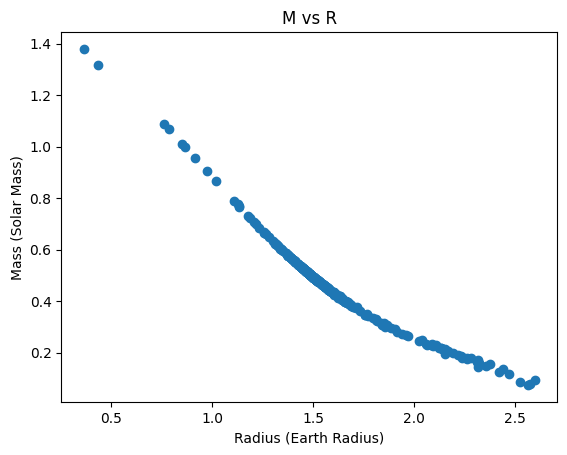

####################### PART C #########################


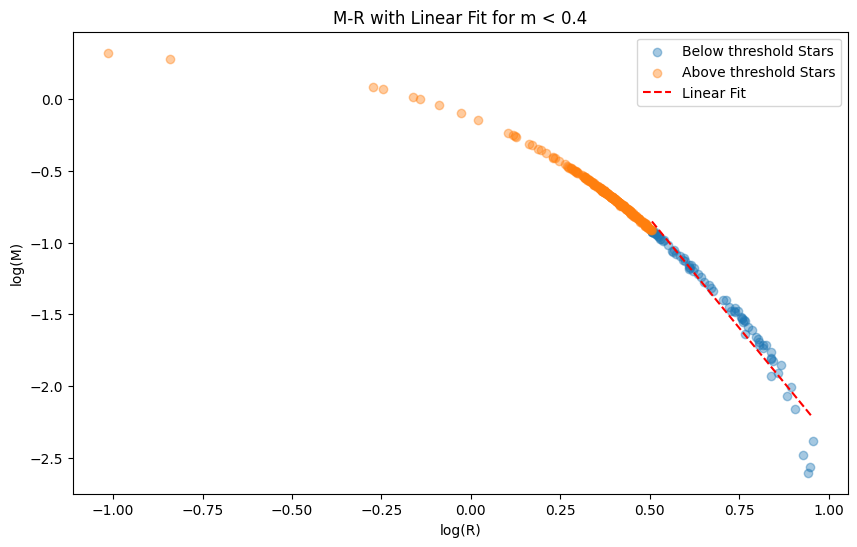

Calculated slope: -3.040


C:\Users\omerr\AppData\Local\Temp\ipykernel_21576\2280816394.py:17: RuntimeWarning: invalid value encountered in float_power
  f[1] = -np.float_power(y[0], nstar) - (2/t) * y[1]


xi_final: 3.654
theta_prime_final: -0.203
The K* value (scaled): 2.735e-01
The K* value (MKS): 2.849e+06


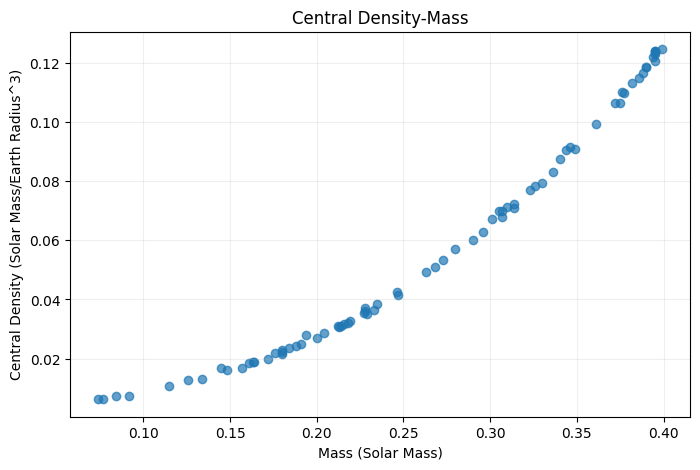

####################### PART D #########################


C:\Users\omerr\AppData\Local\Temp\ipykernel_21576\1964443974.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhs[1] = (1/df_dx)*q*D*np.float_power(y[1]/D, -(1/q)+1) * (-grav_cons*y[0]*y[1]/np.float_power(t, 2))
C:\Users\omerr\AppData\Local\Temp\ipykernel_21576\1964443974.py:10: RuntimeWarning: invalid value encountered in float_power
  x = np.float_power(y[1]/D, 1/q) #Calculate x
C:\Users\omerr\AppData\Local\Temp\ipykernel_21576\1964443974.py:18: RuntimeWarning: invalid value encountered in float_power
  rhs[1] = (1/df_dx)*q*D*np.float_power(y[1]/D, -(1/q)+1) * (-grav_cons*y[0]*y[1]/np.float_power(t, 2))


ln(D) = [45.32027984]  Err = 2.4073078152324756
ln(D) = [45.32027983]  Err = 2.40730781523222
ln(D) = [45.32025426]  Err = 2.407307814573985
ln(D) = [45.32025427]  Err = 2.4073078145742257
ln(D) = [45.31984649]  Err = 2.4073078040784632
ln(D) = [45.3198465]  Err = 2.407307804078721
ln(D) = [45.31821542]  Err = 2.4073077620636605
ln(D) = [45.31821543]  Err = 2.4073077620639127
ln(D) = [45.31169113]  Err = 2.407307593548791
ln(D) = [45.31169114]  Err = 2.4073075935490467
ln(D) = [45.28559399]  Err = 2.4073069121136474
ln(D) = [45.285594]  Err = 2.4073069121139095
ln(D) = [45.18120541]  Err = 2.407304064665217
ln(D) = [45.18120542]  Err = 2.4073040646655004
ln(D) = [44.76365107]  Err = 2.4072904695212136
ln(D) = [44.76365108]  Err = 2.407290469521585
ln(D) = [43.09343374]  Err = 2.407176063145632
ln(D) = [43.09343375]  Err = 2.4071760631467485
ln(D) = [36.41256441]  Err = 2.392840756910458
ln(D) = [36.41256442]  Err = 2.3928407570055916
ln(D) = [10.]  Err = 0.49148720584812905
ln(D) = [10

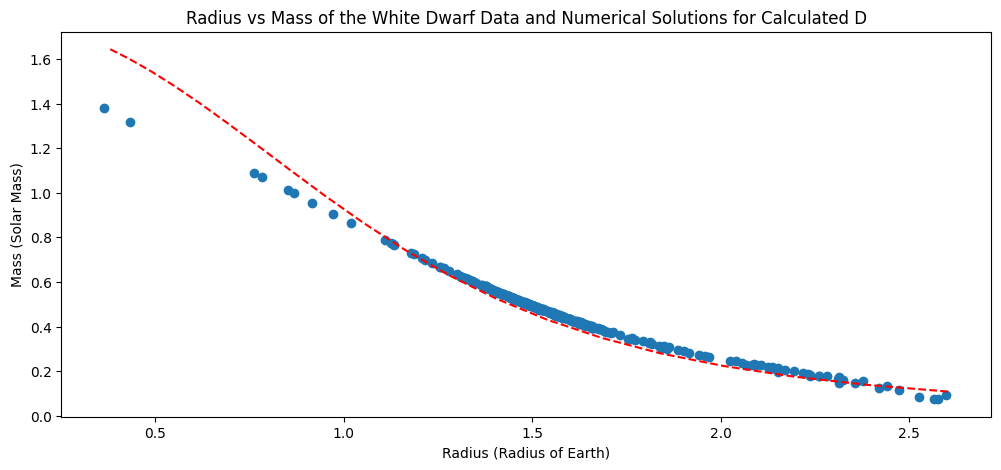

In [447]:
my_tests_newton()